In [10]:
# -*- coding: utf-8 -*-

"""This file is designated for executing the AlphaPEM software package.
"""

# _____________________________________________________Preliminaries____________________________________________________

# Importing the necessary libraries
import time
import numpy as np
import sys
import os

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath("../external/AlphaPEM"))
# Importing constants' value and functions
from configuration.settings import current_density_parameters, operating_inputs, physical_parameters, \
                                   computing_parameters
from model.AlphaPEM import AlphaPEM
from modules.main_modules import figures_preparation, plot_saving

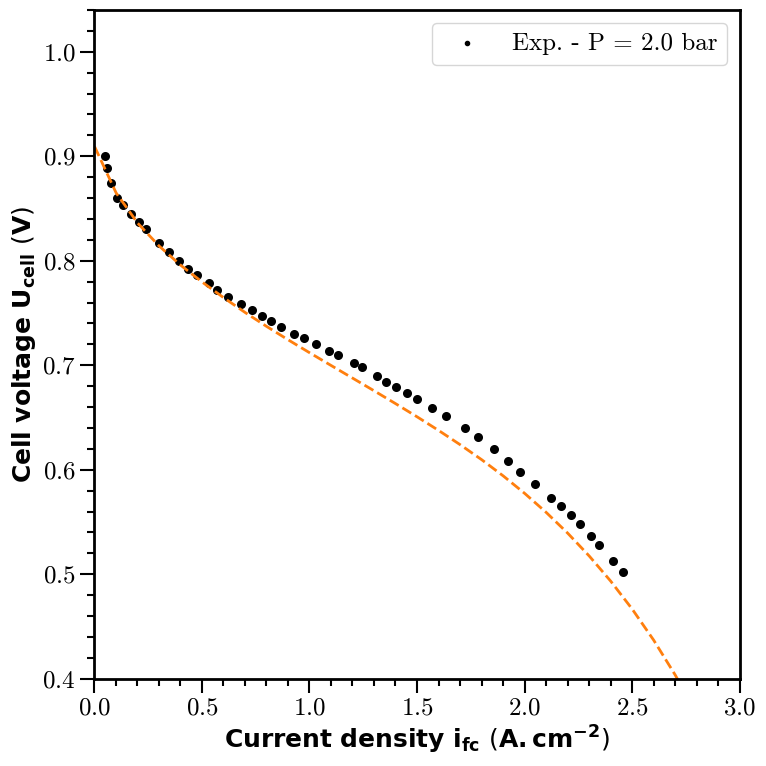

In [11]:


# __________________________________________________AlphaPEM settings___________________________________________________
"""
- Users can select various preconfigured configurations for execution.
- Adjustments to these configurations can be made within setting.py or current_densities.py and their associated files.
- Selecting different type_fuel_cell during a single run results in simultaneous plots for various configurations.
"""


# Starting time
start_time = time.time()

# Fuel cell possibilities: "EH-31_1.5"(2021), "EH-31_2.0"(2021), "EH-31_2.25"(2021), "EH-31_2.5"(2021),
#                          "LF"(2010), "manual_setup".
# This parameter includes the fuel cell used in the model and the corresponding operating conditions.
# - EH-31 is a fuel cell developed by EH GROUP. 1.5, 2.0, 2.25 and 2.5 corresponds to the different pressure options.
# - LF corresponds to the fuel cell used in Linhao Fan work: http://dx.doi.org/10.1016/j.enconman.2017.08.034.
type_fuel_cell_1 = "EH-31_2.0"
type_fuel_cell_2 = None
type_fuel_cell_3 = None
type_fuel_cell_4 = None
# Current density possibilities: "step", "polarization", "EIS".
type_current = "polarization"
# Auxiliary system possibilities: "forced-convective_cathode_with_anodic_recirculation",
#                                 "forced-convective_cathode_with_flow-through_anode", "no_auxiliary".
type_auxiliary = "forced-convective_cathode_with_flow-through_anode"
# Control strategy for the operating inputs: "Phi_des", "no_control".
type_control_1 = "no_control"
type_control_2 = "no_control"
type_control_3 = "no_control"
type_control_4 = "no_control"
# Purges possibilities: "constant_purge", "periodic_purge", "no_purge".
type_purge = "no_purge"
# Display possibilities: "multiple", "synthetic", "no_display".
type_display = "synthetic"
# Plot possibilities: "dynamic", "fixed". Using dynamic plot option enables real-time figure updates during program
# execution, albeit at the cost of decreased program speed.
type_plot = "fixed"

# ___________________________________Retrieving parameters from the settings.py file____________________________________
"""This should remain unaltered for regular program usage."""

# Imposed inputs
t_step, i_step, delta_pola, i_EIS, ratio_EIS, f_EIS, t_EIS, current_density = \
    current_density_parameters(type_current)
# Operating conditions
Tfc_1, Pa_des_1, Pc_des_1, Sa_1, Sc_1, Phi_a_des_1, Phi_c_des_1, i_max_pola_1 = \
    operating_inputs(type_fuel_cell_1)
if type_fuel_cell_2 is not None:
    Tfc_2, Pa_des_2, Pc_des_2, Sa_2, Sc_2, Phi_a_des_2, Phi_c_des_2, i_max_pola_2 = \
        operating_inputs(type_fuel_cell_2)
if type_fuel_cell_3 is not None:
    Tfc_3, Pa_des_3, Pc_des_3, Sa_3, Sc_3, Phi_a_des_3, Phi_c_des_3, i_max_pola_3 = \
        operating_inputs(type_fuel_cell_3)
if type_fuel_cell_4 is not None:
    Tfc_4, Pa_des_4, Pc_des_4, Sa_4, Sc_4, Phi_a_des_4, Phi_c_des_4, i_max_pola_4 = \
        operating_inputs(type_fuel_cell_4)
# Physical parameters
Hcl, epsilon_mc, tau, Hmem, Hgdl, epsilon_gdl, epsilon_c, Hgc, Wgc, Lgc, Aact, e, Re, i0_c_ref, kappa_co, \
    kappa_c, a_slim, b_slim, a_switch, C_scl = physical_parameters(type_fuel_cell_1)
# Computing parameters
max_step, n_gdl, t_purge = computing_parameters(type_current, Hgdl, Hcl)

# __________________________________________________________Main________________________________________________________
"""This section is dedicated to ensuring the proper execution of the simulator, considering all the various 
possibilities including real-time figure updates and simultaneous plotting for different configurations. 
This should remain unaltered for regular program usage.
"""

# Check if the type_current is valid
if type_current != "step" and type_current != "polarization" and type_current != "EIS":
    raise ValueError('You have to specify a type_current which is accepted.')

# Figures preparation
fig1, ax1, fig2, ax2, fig3, ax3 = figures_preparation(type_current, type_display)

# Dynamic display requires a dedicated use of the AlphaPEM class.
if type_plot == "dynamic":

    # Check if the type_fuel_cell and type_current are valid
    if type_fuel_cell_2 is not None or type_fuel_cell_3 is not None or type_fuel_cell_4 is not None:
        raise ValueError('dynamic plot is not currently intended for use with different inputs.')
    if type_current == "step" and type_display == "multiple":
        raise ValueError('dynamic plot is not thought to be used with step current and multiple display.' +
                            'There would be too much plots to handle.')

    # Initialization
    #       ... of the plot update number (n) and the initial time interval (time_interval)
    initial_variable_values = None
    if type_current == "step":
        t0_step, tf_step, delta_t_load_step, delta_t_dyn_step = t_step
        n = int(tf_step / delta_t_dyn_step)  # It is the plot update number.
        time_interval = [0, delta_t_dyn_step]  # It is the initial time interval.
    elif type_current == "polarization":
        delta_t_load_pola, delta_t_break_pola, delta_i_pola, delta_t_ini_pola = delta_pola
        delta_t = delta_t_load_pola + delta_t_break_pola  # s. It is the time of one load.
        tf = delta_t_ini_pola + int(i_max_pola_1 / delta_i_pola + 1) * delta_t  # s. It is the polarization current
        #                                                                         duration.
        n = int(tf / delta_t)  # It is the plot update number.
        time_interval = [0, delta_t_ini_pola + delta_t]  # It is the initial time interval.
    elif type_current == "EIS":
        t0_EIS, t_new_start, tf_EIS, delta_t_break_EIS, delta_t_measurement_EIS = t_EIS
        f_power_min_EIS, f_power_max_EIS, nb_f_EIS, nb_points_EIS = f_EIS  # These are used for EIS max_step actualization.
        f = np.logspace(f_power_min_EIS, f_power_max_EIS, num=nb_f_EIS)  # It is a list of all the frequency tested.
        n = len(t_new_start)  # It is the plot update number.
        time_interval = [0, t0_EIS]  # It is the initial time interval.

    #       A preliminary simulation run is necessary to equilibrate the internal variables of the cell at i_EIS
    #       prior to initiating the EIS.
    if type_current == "EIS":
        Simulator1 = AlphaPEM(current_density, Tfc_1, Pa_des_1, Pc_des_1, Sa_1, Sc_1, Phi_a_des_1, Phi_c_des_1,
                                t_step, i_step, i_max_pola_1, delta_pola, i_EIS, ratio_EIS, t_EIS, f_EIS, Aact, Hgdl,
                                Hmem, Hcl, Hgc, Wgc, Lgc, epsilon_gdl, tau, epsilon_mc, epsilon_c, e, Re, i0_c_ref,
                                kappa_co, kappa_c, a_slim, b_slim, a_switch, C_scl, max_step, n_gdl, t_purge,
                                type_fuel_cell_1, type_current, type_auxiliary, type_control_1, type_purge,
                                "no_display", type_plot, initial_variable_values, time_interval)

        # time_interval actualization
        t0_EIS_temp = t0_EIS  # It is the initial time for 1 EIS point.
        tf_EIS_temp = t_new_start[0] + delta_t_break_EIS[0] + delta_t_measurement_EIS[0]  # It is the final time for
        #                                                                                  1 EIS point.
        n_inf = np.where(t_new_start <= t0_EIS_temp)[0][-1]  # It is the number of frequency changes which has been
        #                                                      made.
        max_step = 1 / (f[n_inf] * nb_points_EIS)  # max_step is actualized according to the current frequency
        #                                        for increased calculation
        time_interval = [t0_EIS_temp, tf_EIS_temp]

        # Recovery of the internal states from the end of the preceding simulation.
        initial_variable_values = []
        for x in Simulator1.solver_variable_names:
            initial_variable_values.append(Simulator1.variables[x][-1])

        if type_display == "multiple":
            print("A display bug prevents the dynamic updating of the graphs, as it appears that too much data is "
                    "involved. However, the data is correctly calculated, and the appropriate plots are saved in the "
                    "'results' folder. This display bug does not occur when using a 'synthetic' type_display.")

    # Dynamic simulation
    for i in range(n):
        Simulator1 = AlphaPEM(current_density, Tfc_1, Pa_des_1, Pc_des_1, Sa_1, Sc_1, Phi_a_des_1, Phi_c_des_1,
                                t_step, i_step, i_max_pola_1, delta_pola, i_EIS, ratio_EIS, t_EIS, f_EIS, Aact, Hgdl,
                                Hmem, Hcl, Hgc, Wgc, Lgc, epsilon_gdl, tau, epsilon_mc, epsilon_c, e, Re, i0_c_ref,
                                kappa_co, kappa_c, a_slim, b_slim, a_switch, C_scl, max_step, n_gdl, t_purge,
                                type_fuel_cell_1, type_current, type_auxiliary, type_control_1, type_purge,
                                type_display, type_plot, initial_variable_values, time_interval)

        # time_interval actualization
        if i < (n - 1):  # The final simulation does not require actualization.
            if type_current == "step":
                t0_interval = Simulator1.variables['t'][-1]
                tf_interval = (i + 2) * delta_t_dyn_step
                time_interval = [t0_interval, tf_interval]  # Reset of the time interval
            elif type_current == "polarization":
                t0_interval = Simulator1.variables['t'][-1]
                tf_interval = delta_t_ini_pola + (i + 2) * delta_t
                time_interval = [t0_interval, tf_interval]  # Reset of the time interval
            elif type_current == "EIS":
                t0_EIS_temp = Simulator1.variables['t'][-1]  # It is the initial time for 1 EIS point.
                tf_EIS_temp = t_new_start[i + 1] + delta_t_break_EIS[i + 1] + delta_t_measurement_EIS[i + 1]  # It
                #                                                               is the final time for 1 EIS point.
                n_inf = np.where(t_new_start <= t0_EIS_temp)[0][-1]  # It is the number of frequency changes which
                #                                                      has been made.
                max_step = 1 / (f[n_inf] * nb_points_EIS)  # max_step is actualized according to the current frequency
                #                                        for increased calculation
                time_interval = [t0_EIS_temp, tf_EIS_temp]  # It is the time interval for 1 EIS point.

        # Recovery of the internal states from the end of the preceding simulation.
        initial_variable_values = []
        for x in Simulator1.solver_variable_names:
            initial_variable_values.append(Simulator1.variables[x][-1])

        # Display
        if type_display != "no_display":
            Simulator1.Display(ax1, ax2, ax3)

else:  # elif type_plot == "fixed":

    # Certain conditions must be met.
    if type_current == "step" and \
            (type_fuel_cell_2 is not None or type_fuel_cell_3 is not None or type_fuel_cell_4 is not None):
        raise ValueError('step current contains too much information for a common plot with different inputs.')
    elif type_current == "EIS":
        raise ValueError('EIS has to be plot with a dynamic type_plot setting, '
                            'because max_step has to be adjusted at each frequency.')

    # Simulation
    Simulator1 = AlphaPEM(current_density, Tfc_1, Pa_des_1, Pc_des_1, Sa_1, Sc_1, Phi_a_des_1, Phi_c_des_1, t_step,
                            i_step, i_max_pola_1, delta_pola, i_EIS, ratio_EIS, t_EIS, f_EIS, Aact, Hgdl, Hmem, Hcl,
                            Hgc, Wgc, Lgc, epsilon_gdl, tau, epsilon_mc, epsilon_c, e, Re, i0_c_ref, kappa_co,
                            kappa_c, a_slim, b_slim, a_switch, C_scl, max_step, n_gdl, t_purge, type_fuel_cell_1,
                            type_current, type_auxiliary, type_control_1, type_purge, type_display, type_plot)
    if type_fuel_cell_2 is not None:
        Simulator2 = AlphaPEM(current_density, Tfc_2, Pa_des_2, Pc_des_2, Sa_2, Sc_2, Phi_a_des_2, Phi_c_des_2,
                                t_step, i_step, i_max_pola_2, delta_pola, i_EIS, ratio_EIS, t_EIS, f_EIS, Aact, Hgdl,
                                Hmem, Hcl, Hgc, Wgc, Lgc, epsilon_gdl, tau, epsilon_mc, epsilon_c, e, Re, i0_c_ref,
                                kappa_co, kappa_c, a_slim, b_slim, a_switch, C_scl, max_step, n_gdl, t_purge,
                                type_fuel_cell_2, type_current, type_auxiliary, type_control_2, type_purge,
                                type_display, type_plot)
    if type_fuel_cell_3 is not None:
        Simulator3 = AlphaPEM(current_density, Tfc_3, Pa_des_3, Pc_des_3, Sa_3, Sc_3, Phi_a_des_3, Phi_c_des_3,
                                t_step, i_step, i_max_pola_3, delta_pola, i_EIS, ratio_EIS, t_EIS, f_EIS, Aact, Hgdl,
                                Hmem, Hcl, Hgc, Wgc, Lgc, epsilon_gdl, tau, epsilon_mc, epsilon_c, e, Re, i0_c_ref,
                                kappa_co, kappa_c, a_slim, b_slim, a_switch, C_scl, max_step, n_gdl, t_purge,
                                type_fuel_cell_3, type_current, type_auxiliary, type_control_3, type_purge,
                                type_display, type_plot)
    if type_fuel_cell_4 is not None:
        Simulator4 = AlphaPEM(current_density, Tfc_4, Pa_des_4, Pc_des_4, Sa_4, Sc_4, Phi_a_des_4, Phi_c_des_4,
                                t_step, i_step, i_max_pola_4, delta_pola, i_EIS, ratio_EIS, t_EIS, f_EIS, Aact, Hgdl,
                                Hmem, Hcl, Hgc, Wgc, Lgc, epsilon_gdl, tau, epsilon_mc, epsilon_c, e, Re, i0_c_ref,
                                kappa_co, kappa_c, a_slim, b_slim, a_switch, C_scl, max_step, n_gdl, t_purge,
                                type_fuel_cell_4, type_current, type_auxiliary, type_control_4, type_purge,
                                type_display, type_plot)

    # Display
    if type_display != "no_display":
        Simulator1.Display(ax1, ax2, ax3)
        if type_fuel_cell_2 is not None:
            Simulator2.Display(ax1, ax2, ax3)
        if type_fuel_cell_3 is not None:
            Simulator3.Display(ax1, ax2, ax3)
        if type_fuel_cell_4 is not None:
            Simulator4.Display(ax1, ax2, ax3)




In [28]:
import pandas as pd

max_len = max(len(lst) for lst in Simulator1.variables.values())

# Pad all to max_len
for k in Simulator1.variables:
    Simulator1.variables[k] += [None] * (max_len - len(Simulator1.variables[k]))

pd.DataFrame(Simulator1.variables)
        

,C_v_agc,C_v_agdl_1,C_v_agdl_2,C_v_agdl_3,C_v_agdl_4,C_v_agdl_5,C_v_agdl_6,C_v_agdl_7,C_v_agdl_8,C_v_agdl_9,...,t,Ucell,S_sorp_acl,S_sorp_ccl,J_lambda_mem_acl,J_lambda_mem_ccl,Pagc,Pcgc,Phi_a_des,Phi_c_des
0,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,...,0.000000,0.957784,0.000000,0.000000,0.000000e+00,0.000000e+00,200000.000000,200000.000000,None,None
1,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,...,0.000002,0.957783,-0.000775,-0.002964,1.934419e-08,-7.417817e-08,200000.000014,200000.000000,None,None
2,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,...,0.000005,0.957783,-0.001547,-0.005907,3.868511e-08,-1.483523e-07,200000.000028,200000.000000,None,None
3,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,...,0.000030,0.957781,-0.009210,-0.034612,2.319279e-07,-8.898436e-07,200000.000168,200000.000000,None,None
4,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,6.395155,...,0.000055,0.957780,-0.016833,-0.062887,4.250283e-07,-1.631072e-06,200000.000289,200000.000000,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19223,11.073532,11.104827,11.111974,11.119113,11.126243,11.133365,11.140479,11.147584,11.154680,11.161769,...,1919.628121,0.277055,-1313.914488,-14891.115293,-1.234164e-02,-1.233356e-02,200000.000812,200000.017922,None,None
19224,11.073482,11.104777,11.111924,11.119063,11.126193,11.133315,11.140428,11.147533,11.154630,11.161718,...,1919.728121,0.277035,-1313.902093,-14891.372227,-1.234142e-02,-1.233313e-02,200000.000830,200000.018398,None,None
19225,11.073431,11.104726,11.111872,11.119011,11.126141,11.133263,11.140376,11.147481,11.154578,11.161666,...,1919.828121,0.277015,-1313.889237,-14891.635998,-1.234119e-02,-1.233269e-02,200000.000848,200000.018885,None,None
19226,11.073378,11.104673,11.111820,11.118958,11.126088,11.133210,11.140323,11.147428,11.154524,11.161613,...,1919.928121,0.276994,-1313.875908,-14891.906779,-1.234095e-02,-1.233224e-02,200000.000867,200000.019385,None,None


In [ ]:
# Plot saving
plot_saving(type_fuel_cell_1, type_current, type_display, fig1, fig2, fig3)

# Ending time
algo_time = time.time() - start_time
print('Time of the algorithm in second :', algo_time)